Single objects inspection; apply GAIA->LS filter transformation

In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import sys, os, glob, time, warnings, gc

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    return ax

def binned_stats(x, y, bins):
    from scipy import stats
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    bin_center, bin_median, bin_scatter = np.zeros((3, len(bins)-1))
    for index in range(len(bins)-1):
        mask = (x>bins[index]) & (x<bins[index+1])
        bin_center[index] = np.median(x[mask])
        if np.sum(mask)>0:
            bin_median[index] = np.median(y[mask])
            bin_scatter[index] = nmad(y[mask])
        else:
            bin_median[index], bin_scatter[index] = np.nan, np.nan
    return bin_center, bin_median, bin_scatter

-------

In [4]:
# gaia1 and gaia2: DECaLS/DES SGC; gaia3: BASS/MzLS; gaia4: DECaLS NGC
gaia_fn = 'gaia4.fits.gz'
field = 'south'
# gaia_fn = 'gaia3.fits.gz'
# field = 'north'
gaia = Table.read('/Users/rongpu/Documents/Data/desi_misc/gaia_from_arjun/'+gaia_fn)
print(len(gaia))

if (gaia_fn=='gaia1.fits.gz') or (gaia_fn=='gaia2.fits.gz'):
    mask = gaia['dec']<31.
    gaia = gaia[mask]
    print(len(gaia))
                                  
if (gaia_fn=='gaia3.fits.gz'):
    mask = gaia['dec']>32.375
    gaia = gaia[mask]
    print(len(gaia))
    
# Remove the globular cluster in DECaLS
mask = (gaia['ra']>198.0) & (gaia['ra']<198.5) & (gaia['dec']>18.0) & (gaia['dec']<18.4) 
gaia = gaia[~mask]
print(len(gaia))

603673
602678


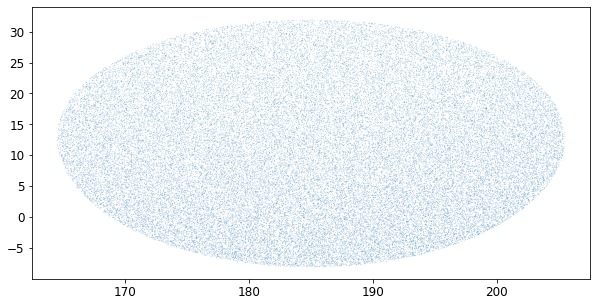

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(gaia['ra'][::10], gaia['dec'][::10], '.', ms=0.2, alpha=0.5)
plt.show()

In [6]:
# Remove duplicates
if len(np.unique(gaia['source_id']))<len(gaia):
    print('Duplicates exist!')
    gaia.sort('source_id')
    mask = gaia['source_id'][1:]==gaia['source_id'][:-1]
    mask = np.concatenate([[False], mask])
    gaia = gaia[~mask]
    
# Remove objects with invalide mask = np.isfinite(gaia['bp_rp'])
mask = np.isfinite(gaia['bp_rp'])
if np.sum(~mask)>0:
    print('{} objects with invalid bp_rp'.format(np.sum(~mask)))
    gaia = gaia[mask]

12931 objects with invalid bp_rp


In [7]:
# Apply GAIA-LS transformation
from scipy.interpolate import interp1d
transform_interp = {}
for band in ['g', 'r', 'z']:
    if field=='north':
        tmp = Table.read('../data/gaia_bassmzls_transform.txt', format='ascii.commented_header')
    else:
        tmp = Table.read('../data/gaia_decals_transform.txt', format='ascii.commented_header')
    transform_interp[band] = interp1d(tmp['bp_rp'], tmp['ls_'+band], bounds_error=False, fill_value='extrapolate', kind='linear')
    gaia['ls_'+band] = gaia['phot_g_mean_mag'] + transform_interp[band](gaia['bp_rp'])

-----

In [8]:
gaia[-3:]

source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_excess_noise,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val,ls_g,ls_r,ls_z
,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mag,mag,km / s,km / s,,K,mag,mag,mag,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,bytes13,float32,float32,float64,float64,float64
3994610272962041472,171.69602666517977,0.04197997433305863,26.62624430221581,0.04112424633890574,1.618217811435505,0.04937989470902585,12.41447683309527,0.07637444167023606,-28.784777220089065,0.08742310173056753,0.08302630680622912,15.500369,1.3225746,nan,nan,NOT_AVAILABLE,4983.3667,nan,16.2634589365534,15.348829472355268,14.91922234929534
3994690502951116672,171.4515696821848,0.04685246445713802,27.15704450663394,0.03629249737651734,5.114811482290368,0.05047609886925953,-26.080063795037862,0.08330833197404058,-40.92511168657887,0.06976791378596633,0.0,9.774005,0.6353178,-33.89483198762582,0.530979419804223,NOT_AVAILABLE,6318.5,nan,9.997106346106008,9.729998094869478,9.690288707977345
3994608486255670784,171.76225290056712,0.04947338320853655,26.606800560464155,0.04908123133875376,0.5334451758299782,0.06063156235722681,-5.36746282591889,0.09491786742429932,-14.196738274125847,0.10820930430891462,0.0,15.583411,0.8197174,nan,nan,NOT_AVAILABLE,5791.7275,0.1995,15.92397208412833,15.500380581423892,15.371397587189032


In [9]:
band = 'g'
source_id_list = [3994610272962041472]

download_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/cutouts/'
# img_type = '-resid'
img_type = ''
pixscale_str = '0.262'
pixscale = float(pixscale_str)
size_str = '512'

individual_plot_q = True
show_q = True
plot_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/plots/11/'

verbose = True

phot_g_mean_mag =  15.500369
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/cutouts/south/gaia4/3994610272962041472_g_0.262_512.fits "http://legacysurvey.org/viewer/cutout.fits?ra=171.696027&dec=26.626244&layer=dr8-south&pixscale=0.262&bands=g&size=512"


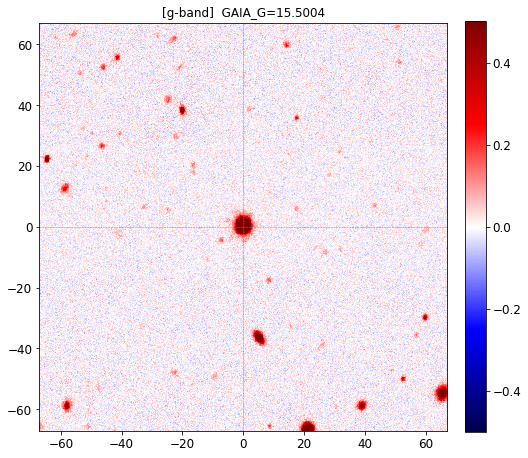

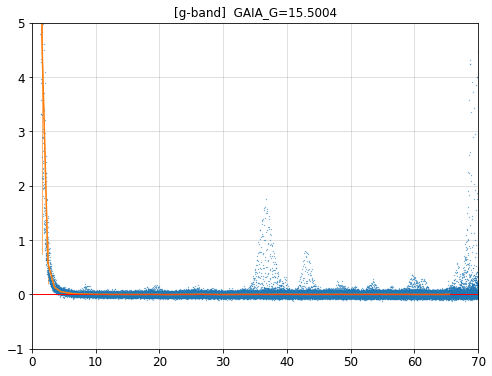

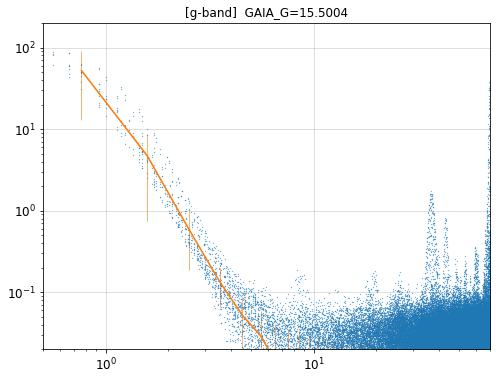

In [10]:
for source_id in source_id_list:

    index = np.where(gaia['source_id']==source_id)[0][0]
    if verbose:
        print('phot_g_mean_mag = ', gaia['phot_g_mean_mag'][index])

    ra, dec = gaia['ra'][index], gaia['dec'][index]

    file_path = os.path.join(download_dir, field, gaia_fn[:-8], '{}_{}{}_{}_{}.fits'.format(gaia['source_id'][index], band, img_type, pixscale_str, size_str))
    if not os.path.exists(os.path.dirname(file_path)):
        os.makedirs(os.path.dirname(file_path))

    if not os.path.isfile(file_path):
        url = 'http://legacysurvey.org/viewer/cutout.fits?ra={:f}&dec={:f}&layer=dr8-{}{}&pixscale={}&bands={}&size={}'.format(ra, dec, field, img_type, pixscale_str, band, size_str)
        cmd = 'wget -O '+file_path+' \"'+url+'\"'
        if verbose:
            print(cmd)
        os.system(cmd)

    img_raw = fitsio.read(file_path)
    img = img_raw / (pixscale**2)

    grid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius = np.sqrt(xx**2 + yy**2).flatten()
    max_radius = xx.flatten().max() # maximum radius before hitting the edge of the image

    # Remove masked pixels
    mask = img.flatten()!=0
    radius = radius[mask]
    flux = img.flatten()[mask]

    bin_center, bin_median, bin_scatter = binned_stats(radius, flux, bins=np.linspace(0., np.floor(max_radius), int(np.floor(max_radius)+1)))

    if individual_plot_q:
        vrange = 0.5
        ax = plot_cutout(img, pixscale, vmin=-vrange, vmax=vrange)
        ax.set_title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
        # plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_image.png'))
        plt.show()

        plt.figure(figsize=(8, 6))
        plt.plot(radius, flux, '.', ms=0.5)
        plt.plot(bin_center, bin_median, c='C1')
        plt.errorbar(bin_center, bin_median, yerr=bin_scatter, lw=1, alpha=0.6, c='C1')
        plt.axis([0, 70, -1, 5])
        plt.axhline(0, lw=1, color='r')
        plt.grid(alpha=0.5)
        plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
        # plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile.png'))
        plt.show()

        plt.figure(figsize=(8, 6))
        plt.loglog(radius, flux, '.', ms=0.5)
        plt.plot(bin_center, bin_median, c='C1')
        plt.errorbar(bin_center, bin_median, yerr=bin_scatter, lw=1, alpha=0.6, c='C1')
        plt.axis([.5, 70, .02, 200])
        plt.grid(alpha=0.5)
        plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
        # plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile_log.png'))
        plt.show()